In [2]:
from functions.utils.func import *

from prep_factor import PrepFactor

stock = read_stock(get_load_data_large_dir() / 'tickers_to_train_fundamental.csv')
start='2006-01-01'
end='2022-01-01'

In [3]:
ret = PrepFactor(factor_name='factor_ret', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()
sb_fama = PrepFactor(factor_name='factor_sb_fama', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (2128883, 11)
Creating factor_sb_fama ------------------------------------ | ✔
Shape: (2128883, 14)


In [4]:
sb_macro = PrepFactor(factor_name='factor_sb_macro', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_sb_macro ----------------------------------- | ✔
Shape: (2797856, 28)


In [5]:
volatility = PrepFactor(factor_name='factor_volatility', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_volatility --------------------------------- | ✔
Shape: (2128883, 11)


# Underlying Stupid WRDS Data

In [10]:
dates_with_counts = ret.groupby(level='date').size()
filtered_dates = dates_with_counts[dates_with_counts < 10].index.tolist()
filtered_df = ret[ret.index.get_level_values('date').isin(filtered_dates)]
for date, group in filtered_df.groupby(level='date'):
    tickers = group.index.get_level_values('ticker').tolist()
    print(f"Date: {date} | Tickers: {tickers}")

In [47]:
def remove_date(df, threshold):
    dates_with_counts = df.groupby(level='date').size()
    valid_dates = dates_with_counts[dates_with_counts >= threshold].index.tolist()
    return df[df.index.get_level_values('date').isin(valid_dates)]

In [12]:
x = remove_date(ret, 10)

In [14]:
x.loc[x.index.get_level_values(1)=='2021-12-06']

,,RET_01,RET_02,RET_03,RET_04,RET_05,RET_10,RET_20,RET_40,RET_60,RET_120,RET_210
permno,date,,,,,,,,,,,
10104,2021-12-06,0.007933,-0.011668,-0.009025,-0.019837,-0.043039,-0.053528,-0.063296,-0.057739,-0.008252,0.153866,0.398428
10107,2021-12-06,0.009845,-0.010015,-0.011785,-0.013310,-0.031013,-0.049314,-0.029370,0.106291,0.103074,0.267348,0.346780
10138,2021-12-06,0.008845,-0.021763,0.006632,-0.013103,-0.046807,-0.062743,-0.107387,0.010084,-0.088966,0.007454,0.234393
10145,2021-12-06,0.013514,0.011029,0.034249,0.019828,-0.006790,-0.056021,-0.087632,-0.052595,-0.072492,-0.058176,0.016410
10516,2021-12-06,0.009276,0.011378,0.020867,0.014467,-0.026231,-0.034129,-0.021399,-0.002844,0.053765,-0.013752,0.184053
...,...,...,...,...,...,...,...,...,...,...,...,...
93114,2021-12-06,0.010819,0.000635,0.016691,0.004007,-0.016766,-0.028378,-0.028121,0.039408,0.020739,0.076976,0.163220
93132,2021-12-06,-0.035599,-0.067293,-0.043307,-0.120653,-0.149315,-0.147353,-0.144055,-0.049256,-0.059422,0.268250,0.878312
93142,2021-12-06,-0.002881,0.001930,0.002252,0.000642,0.002145,-0.000642,-0.011215,-0.003518,-0.020951,-0.010377,-0.028280


In [51]:
dates_with_counts = x.groupby(level='date').size()
filtered_dates = dates_with_counts[dates_with_counts < 10].index.tolist()
filtered_df = x[x.index.get_level_values('date').isin(filtered_dates)]
for date, group in filtered_df.groupby(level='date'):
    tickers = group.index.get_level_values('ticker').tolist()
    print(f"Date: {date} | Tickers: {tickers}")

# EWO

In [9]:
n_splits = (get_timeframe_length(ret)) // 21

def ewo(data, n_splits, lookahead, train_period_length, test_period_length):
    unique_dates = data.index.get_level_values('date').unique()
    days = sorted(unique_dates)
    split_idx = []

    for i in range(n_splits):
        # Training window starts from the first available data point and expands
        train_start_idx = 0
        train_end_idx = i * test_period_length + train_period_length - 1
        
        # Test window immediately follows training data
        test_start_idx = train_end_idx + lookahead
        test_end_idx = test_start_idx + test_period_length - 1

        # Ensure test_end_idx does not go beyond available data
        if test_end_idx >= len(days):
            break
        
        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])
    print(split_idx)
    dates = data.reset_index()[['date']]
    for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(days[train_start] <= dates.date) & (dates.date <= days[train_end])].index
        test_idx = dates[(days[test_start] <= dates.date) & (dates.date <= days[test_end])].index
        yield train_idx, test_idx

In [10]:
len(ret.index.get_level_values('date').unique())

4031

In [20]:
exp = ewo(ret, n_splits, 1, 504, 21)

for i in exp:
    break

[[0, 503, 504, 524], [0, 524, 525, 545], [0, 545, 546, 566], [0, 566, 567, 587], [0, 587, 588, 608], [0, 608, 609, 629], [0, 629, 630, 650], [0, 650, 651, 671], [0, 671, 672, 692], [0, 692, 693, 713], [0, 713, 714, 734], [0, 734, 735, 755], [0, 755, 756, 776], [0, 776, 777, 797], [0, 797, 798, 818], [0, 818, 819, 839], [0, 839, 840, 860], [0, 860, 861, 881], [0, 881, 882, 902], [0, 902, 903, 923], [0, 923, 924, 944], [0, 944, 945, 965], [0, 965, 966, 986], [0, 986, 987, 1007], [0, 1007, 1008, 1028], [0, 1028, 1029, 1049], [0, 1049, 1050, 1070], [0, 1070, 1071, 1091], [0, 1091, 1092, 1112], [0, 1112, 1113, 1133], [0, 1133, 1134, 1154], [0, 1154, 1155, 1175], [0, 1175, 1176, 1196], [0, 1196, 1197, 1217], [0, 1217, 1218, 1238], [0, 1238, 1239, 1259], [0, 1259, 1260, 1280], [0, 1280, 1281, 1301], [0, 1301, 1302, 1322], [0, 1322, 1323, 1343], [0, 1343, 1344, 1364], [0, 1364, 1365, 1385], [0, 1385, 1386, 1406], [0, 1406, 1407, 1427], [0, 1427, 1428, 1448], [0, 1448, 1449, 1469], [0, 1469, 14

# WFO

In [28]:
n_splits = (get_timeframe_length(ret) - 504) // 21

def wfo(data, n_splits, lookahead, train_period_length, test_period_length):
    unique_dates = data.index.get_level_values('date').unique()
    days = sorted(unique_dates)
    split_idx = []

    for i in range(n_splits):
        train_start_idx = i * test_period_length
        train_end_idx = train_start_idx + train_period_length - 1
        test_start_idx = train_end_idx + lookahead
        test_end_idx = test_start_idx + test_period_length - 1

        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

    dates = data.reset_index()[['date']]
    print(split_idx)
    for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(days[train_start] <= dates.date) & (dates.date <= days[train_end])].index
        test_idx = dates[(days[test_start] <= dates.date) & (dates.date <= days[test_end])].index
        yield train_idx, test_idx

In [29]:
walk = wfo(ret, n_splits, 1, 504, 21)

for i in walk:
    print(i[0][:505])

[[0, 503, 504, 524], [21, 524, 525, 545], [42, 545, 546, 566], [63, 566, 567, 587], [84, 587, 588, 608], [105, 608, 609, 629], [126, 629, 630, 650], [147, 650, 651, 671], [168, 671, 672, 692], [189, 692, 693, 713], [210, 713, 714, 734], [231, 734, 735, 755], [252, 755, 756, 776], [273, 776, 777, 797], [294, 797, 798, 818], [315, 818, 819, 839], [336, 839, 840, 860], [357, 860, 861, 881], [378, 881, 882, 902], [399, 902, 903, 923], [420, 923, 924, 944], [441, 944, 945, 965], [462, 965, 966, 986], [483, 986, 987, 1007], [504, 1007, 1008, 1028], [525, 1028, 1029, 1049], [546, 1049, 1050, 1070], [567, 1070, 1071, 1091], [588, 1091, 1092, 1112], [609, 1112, 1113, 1133], [630, 1133, 1134, 1154], [651, 1154, 1155, 1175], [672, 1175, 1176, 1196], [693, 1196, 1197, 1217], [714, 1217, 1218, 1238], [735, 1238, 1239, 1259], [756, 1259, 1260, 1280], [777, 1280, 1281, 1301], [798, 1301, 1302, 1322], [819, 1322, 1323, 1343], [840, 1343, 1344, 1364], [861, 1364, 1365, 1385], [882, 1385, 1386, 1406], [

Int64Index([ 483,  484,  485,  486,  487,  488,  489,  490,  491,  492,
            ...
             978,  979,  980,  981,  982,  983,  984,  985,  986, 4511],
           dtype='int64', length=505)
Int64Index([ 504,  505,  506,  507,  508,  509,  510,  511,  512,  513,
            ...
             999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 4532],
           dtype='int64', length=505)
Int64Index([ 525,  526,  527,  528,  529,  530,  531,  532,  533,  534,
            ...
            1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 4553],
           dtype='int64', length=505)
Int64Index([ 546,  547,  548,  549,  550,  551,  552,  553,  554,  555,
            ...
            1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 4574],
           dtype='int64', length=505)
Int64Index([ 567,  568,  569,  570,  571,  572,  573,  574,  575,  576,
            ...
            1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 4595],
           dtype='int64', length=505)
Int64

Int64Index([1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374,
            ...
            1860, 1861, 1862, 1863, 1864, 1865, 1866, 5393, 5394, 5395],
           dtype='int64', length=505)
Int64Index([1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395,
            ...
            1881, 1882, 1883, 1884, 1885, 1886, 1887, 5414, 5415, 5416],
           dtype='int64', length=505)
Int64Index([1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416,
            ...
            1902, 1903, 1904, 1905, 1906, 1907, 1908, 5435, 5436, 5437],
           dtype='int64', length=505)
Int64Index([1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437,
            ...
            1923, 1924, 1925, 1926, 1927, 1928, 1929, 5456, 5457, 5458],
           dtype='int64', length=505)
Int64Index([1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458,
            ...
            1944, 1945, 1946, 1947, 1948, 1949, 1950, 5477, 5478, 5479],
           dtype='int64', length=505)
Int64

Int64Index([2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338,
            ...
            2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 6357],
           dtype='int64', length=505)
Int64Index([2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359,
            ...
            2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 6378],
           dtype='int64', length=505)
Int64Index([2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380,
            ...
            2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 6399],
           dtype='int64', length=505)
Int64Index([2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401,
            ...
            2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 6420],
           dtype='int64', length=505)
Int64Index([2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422,
            ...
            2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 6441],
           dtype='int64', length=505)
Int64

Int64Index([3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324,
            ...
            3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 7343],
           dtype='int64', length=505)
Int64Index([3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345,
            ...
            3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 7364],
           dtype='int64', length=505)
Int64Index([3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366,
            ...
            3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 7385],
           dtype='int64', length=505)
Int64Index([3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387,
            ...
            3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 7406],
           dtype='int64', length=505)
Int64Index([3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408,
            ...
            3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 7427],
           dtype='int64', length=505)
Int64

# Plot Scatter

Text(0, 0.5, 'Y Axis')

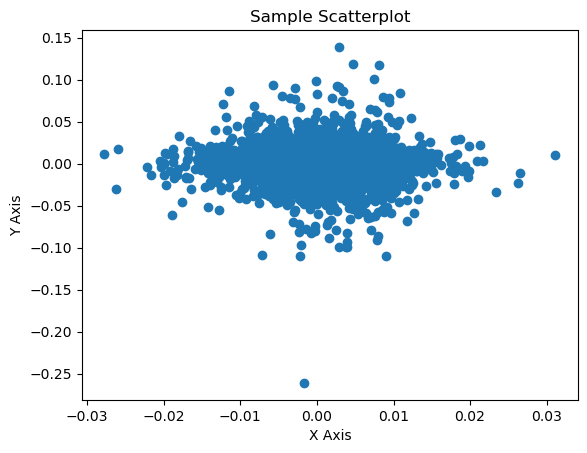

In [56]:
plt.scatter(get_ticker_data(sb_fama, 'A')['SMB_FAMA_30'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

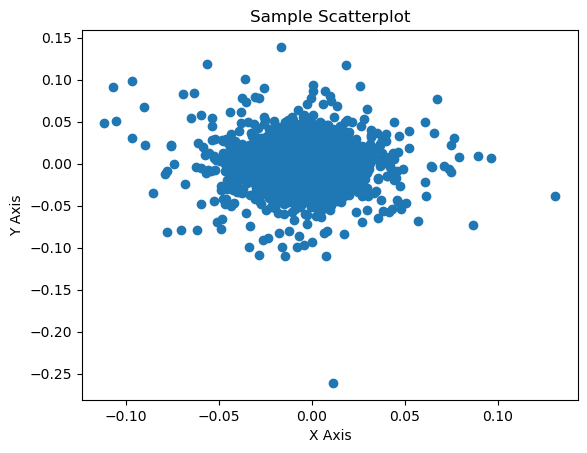

In [57]:
plt.scatter(get_ticker_data(sb_fama, 'A')['PRED_FAMA_30'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

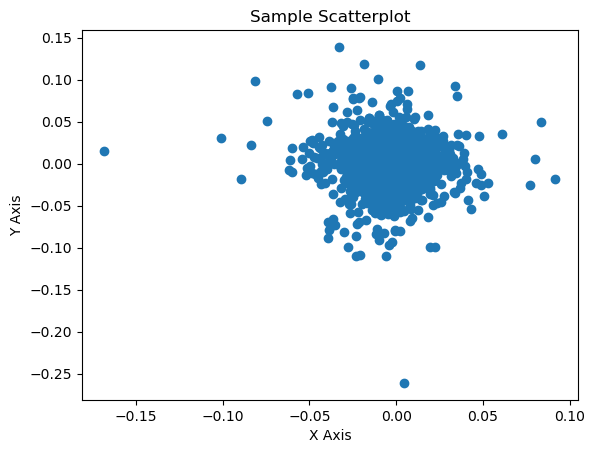

In [70]:
plt.scatter(get_ticker_data(sb_macro, 'A')['PRED_MACRO_60'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

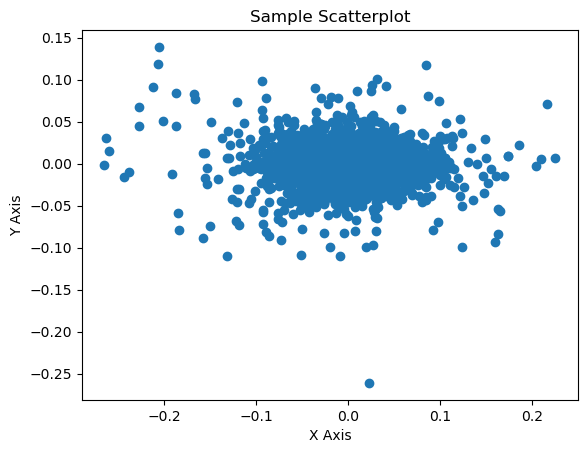

In [66]:
plt.scatter(get_ticker_data(ret, 'A')['RET_05'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

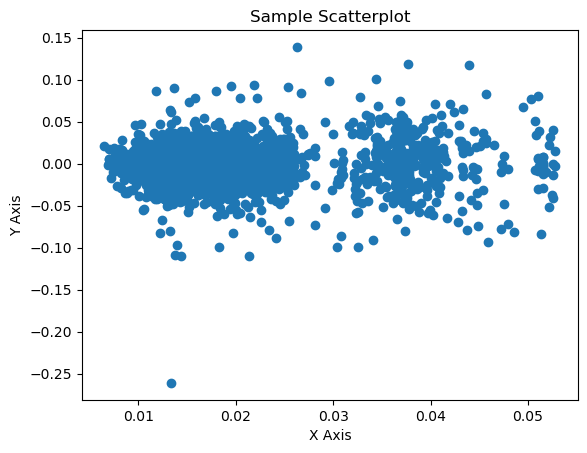

In [78]:
plt.scatter(get_ticker_data(volatility, 'A')['Volatility_01'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

# Rolling Regression

In [283]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
fama_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_fama.parquet.brotli')
bond_df = yf.download(['TLT', 'TIP', 'SHY', 'AGG', 'HYG'], start='2006-01-01', end='2023-01-01')
bond_df = bond_df.stack().swaplevel().sort_index()
bond_df.index.names = ['ticker', 'date']
bond_df = bond_df.astype(float)
T = [1, 6, 30]
bond_df = create_return(bond_df, T)
bond_df = bond_df.drop(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
bond_df = bond_df.unstack('ticker').swaplevel(axis=1)
bond_df.columns = ['_'.join(col).strip() for col in bond_df.columns.values]
bond_data = bond_df
bond_data = pd.concat([bond_data, fama_data['RF']], axis=1)
bond_data = bond_data.loc['2006-01-01':'2023-01-01']
bond_data = bond_data.fillna(0)
factor_col = bond_data.columns[:-1]

[*********************100%%**********************]  5 of 5 completed


In [284]:
factor_data = set_timeframe(factor_data, '2006-01-01', '2023-01-01')

In [285]:
factor_data = create_return(factor_data, windows=[1])
factor_data = factor_data.fillna(0)

In [286]:
ret = 'RET_01'
window = 20

In [287]:
correlation_matrix = bond_data.corr()

In [288]:
correlation_matrix

,AGG_RET_01,HYG_RET_01,SHY_RET_01,TIP_RET_01,TLT_RET_01,AGG_RET_06,HYG_RET_06,SHY_RET_06,TIP_RET_06,TLT_RET_06,AGG_RET_30,HYG_RET_30,SHY_RET_30,TIP_RET_30,TLT_RET_30,RF
AGG_RET_01,1.000000,0.224753,0.549972,0.646263,0.661742,0.392333,0.111294,0.219394,0.268699,0.253646,0.180591,0.018989,0.121181,0.127658,0.137316,0.000425
HYG_RET_01,0.224753,1.000000,-0.078685,0.060411,-0.188704,0.118739,0.393492,-0.052898,0.082145,-0.045306,0.092341,0.159700,-0.001519,0.070225,0.031518,-0.012210
SHY_RET_01,0.549972,-0.078685,1.000000,0.558996,0.537129,0.230568,-0.038528,0.397426,0.199140,0.197443,0.105752,-0.031768,0.198589,0.090581,0.096372,0.022884
TIP_RET_01,0.646263,0.060411,0.558996,1.000000,0.673721,0.288283,0.081483,0.230953,0.404381,0.223923,0.129586,0.031982,0.100888,0.182624,0.105131,-0.007681
TLT_RET_01,0.661742,-0.188704,0.537129,0.673721,1.000000,0.306711,-0.046819,0.260439,0.277891,0.392535,0.136792,-0.060659,0.134215,0.122465,0.186837,0.001763
AGG_RET_06,0.392333,0.118739,0.230568,0.288283,0.306711,1.000000,0.307674,0.587875,0.714983,0.726609,0.441596,0.066837,0.305468,0.327376,0.362474,0.001557
HYG_RET_06,0.111294,0.393492,-0.038528,0.081483,-0.046819,0.307674,1.000000,-0.113976,0.239028,-0.111518,0.228082,0.387776,-0.003097,0.211665,0.093528,-0.031725
SHY_RET_06,0.219394,-0.052898,0.397426,0.230953,0.260439,0.587875,-0.113976,1.000000,0.497890,0.553929,0.266523,-0.106893,0.480126,0.209509,0.264455,0.063113
TIP_RET_06,0.268699,0.082145,0.199140,0.404381,0.277891,0.714983,0.239028,0.497890,1.000000,0.599812,0.321184,0.099294,0.211016,0.427531,0.256805,-0.014972
TLT_RET_06,0.253646,-0.045306,0.197443,0.223923,0.392535,0.726609,-0.111518,0.553929,0.599812,1.000000,0.347144,-0.136746,0.299787,0.259748,0.457919,0.005949


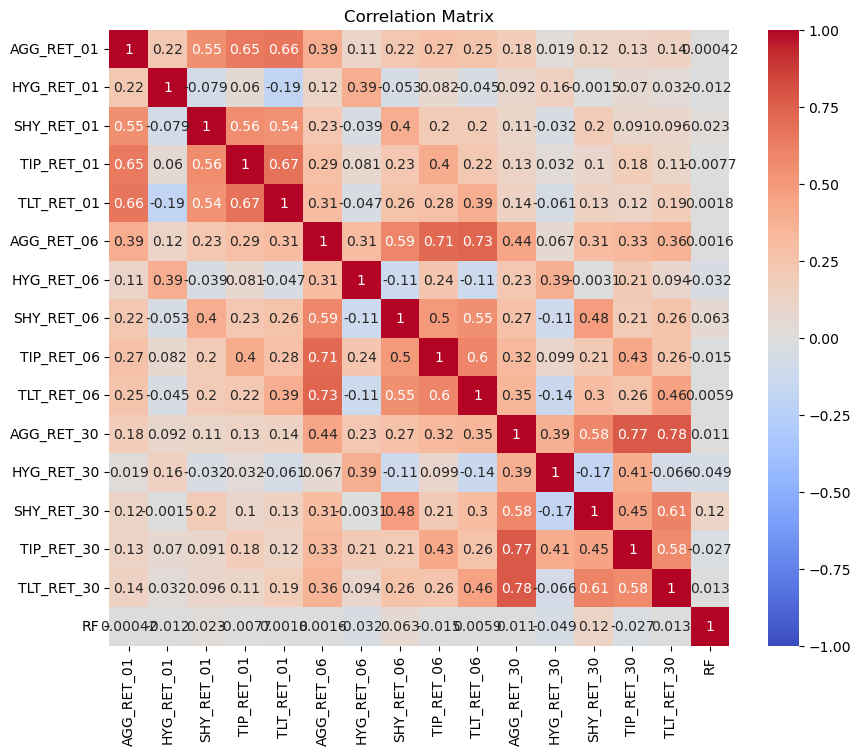

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [264]:
def rolling_ols_beta_res_syn(price, factor_data, factor_col, window, name, ret):
    betas = []
    for stock, df in price.groupby(price.index.names[0], group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF
        rolling_ols = RollingOLS(endog=model_data[ret],
                                 exog=sm.add_constant(model_data[factor_col]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    
        # Compute predictions of stock's return
        alpha = factor_model['ALPHA']
        beta_coef = factor_model[factor_col]
        factor_ret = model_data[factor_col]
        stock_ret = df.reset_index(price.index.names[0]).drop(columns=price.index.names[0], axis=1)[ret]
    
        predictions = []
        epsilons = []
        for index, row in factor_ret.iterrows():
            prediction = row @ beta_coef.loc[index] + alpha.loc[index]
            epsilon = stock_ret.loc[index] - prediction
            predictions.append(prediction)
            epsilons.append(epsilon)
    
        result = factor_model.assign(**{price.index.names[0]: stock}).set_index(price.index.names[0], append=True).swaplevel()
        result['PRED'] = predictions
        result['EPSIL'] = epsilons
        # result['EPSIL_Z'] = result['EPSIL'].rolling(window=window).sum() / result['EPSIL'].rolling(window=window).std()
        result['IDIO_VOL'] = result['EPSIL'].rolling(window=window).std()
        betas.append(result)
        betas.append(result)
        print('---------------------------')
        print(result.index[0])
    
    return pd.concat(betas).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [281]:
def rolling_ols_beta_res_syn(price, factor_data, factor_col, window, name, ret):
    betas = []
    # Prepare the design matrix with constant term (for intercept)
    X = np.column_stack([factor_data[factor_col].values, np.ones(len(factor_data))])
    # Rolling view for X (independent variable)
    X_view = np.lib.stride_tricks.sliding_window_view(X, (window, X.shape[1]))
    X_view = X_view.squeeze(1)

    for stock, df in price.groupby(price.index.names[0]):   
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF
        y = model_data[ret].values
        
        # Rolling view for y (dependent variable)
        y_view = np.lib.stride_tricks.sliding_window_view(y, (window,))
        # Compute rolling betas using matrix operations
        betas_matrix = np.linalg.inv(X_view.transpose(0, 2, 1) @ X_view) @ (X_view.transpose(0, 2, 1) @ y_view[:, :, np.newaxis])
        betas_matrix = betas_matrix.squeeze(axis=-1)
        # Extract all beta coefficients
        betas = [pd.Series(betas_matrix[:, i], index=model_data.index[window - 1:], name=f"BETA_{col}") for i, col in enumerate(factor_col)]
        # Extract y-intercept
        alpha = pd.Series(betas_matrix[:, -1], index=model_data.index[window - 1:], name=f"ALPHA")
        # Calculate predictions
        predictions = sum([model_data[col].iloc[window - 1:] * beta for col, beta in zip(factor_col, betas)]) + alpha
        # Calculate Epsilon
        epsilons = model_data[ret].iloc[window - 1:] - predictions
        # Combine all series into a single DataFrame
        result = pd.concat([alpha] + betas + [pd.Series(predictions, name="PRED"), pd.Series(epsilons, name="EPSIL")], axis=1)
        result['IDIO_VOL'] = result['EPSIL'].rolling(window=window).std()
        # Add stock index back
        result[df.index.names[0]] = stock
        result = result.set_index('permno', append=True).swaplevel()
        betas.append(result)
        print('---------------------------')
        print(result.index[0])

    return pd.concat(betas).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [282]:
y = rolling_ols_beta_res_syn(factor_data, bond_data, factor_col, window, name, ret)

LinAlgError: Singular matrix

In [4]:
sector_df = yf.download(['XLSR', 'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU'], start='2006-01-01', end='2022-01-01')
sector_df = sector_df.stack().swaplevel().sort_index()
sector_df.index.names = ['ticker', 'date']
sector_df = sector_df.astype(float)

[*********************100%%**********************]  12 of 12 completed


In [8]:
sector_df

Adj Close       Close        High         Low        Open  \
ticker date                                                                     
XLB    2006-01-03   20.866495   30.920000   31.010000   30.110001   30.110001   
       2006-01-04   20.994720   31.110001   31.110001   30.809999   30.809999   
       2006-01-05   20.960970   31.059999   31.120001   30.879999   31.120001   
       2006-01-06   21.183678   31.389999   31.510000   31.200001   31.280001   
       2006-01-09   21.176928   31.379999   31.490000   31.309999   31.410000   
...                       ...         ...         ...         ...         ...   
XLY    2021-12-27  202.013016  205.169998  205.789993  203.479996  203.570007   
       2021-12-28  202.101608  205.259995  206.350006  204.910004  205.630005   
       2021-12-29  202.505310  205.669998  206.179993  204.369995  205.759995   
       2021-12-30  201.776688  204.929993  206.729996  204.750000  204.970001   
       2021-12-31  201.294250  204.440002  205.809998  204.300003  205.089996   

                      Volume  
ticker date                   
XLB    2006-01-03  5604600.0  
       2006-01-04  3107500.0  
       2006-01-05  1685500.0  
       2006-01-06   835300.0  
       2006-01-09   883800.0  
...                      ...  
XLY    2021-12-27  4214000.0  
       2021-12-28  4153100.0  
       2021-12-29  3792300.0  
       2021-12-30  3570100.0  
       2021-12-31  3442800.0  

[39408 rows x 6 columns]